In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random
import pulp

# Time Series Analysis of Energy Data

Prompt: "Make a dataset containing power output (in megawatts) from a solar farm recorded hourly over a month. Then write a Python script to analyze the time series data. Your script should identify the peak production hours and any anomalous dips in power generation. Also, include a brief explanation of how weather or other external factors might affect these readings."

Skills Tested: Data manipulation, time series analysis, basic understanding of renewable energy systems.

## Create sample data

In [3]:
sample_df = pd.DataFrame(pd.date_range(start='1/1/2023', end='1/31/2023 23:00', freq='H'), columns=['date'])
sample_df.set_index('date', inplace=True)

# Constants
DAYS = 31
HOURS_IN_DAY = 24
MEAN_SUNLIGHT_HOUR = 12  # Assuming peak sunlight at noon
STD_DEV = 3  # Standard deviation in hours, determines how "spread out" the sunlight hours are
SAMPLE_PEAK_POWER = 10 # in MW

power_output = []
for day in range(DAYS):
    # Create a daily profile centered around noon with 3 hours of spread:
    hours = np.arange(HOURS_IN_DAY)
    daily_power_output = norm.pdf(x=hours, loc=MEAN_SUNLIGHT_HOUR, scale=STD_DEV)
    daily_power_output = np.clip(daily_power_output, a_min=0, a_max=None) # Clip values less than 0
    # Normalize by the maximum, multiply by the sample peak power, then randomly multiply by a value between 0.8-1.1 for daily variety
    daily_power_output = daily_power_output / daily_power_output.max() * SAMPLE_PEAK_POWER * random.uniform(0.8,1.1)
    power_output.extend(daily_power_output)
    
sample_df["power_output"] = power_output

In [4]:
sample_df

,power_output
date,
2023-01-01 00:00:00,0.003683
2023-01-01 01:00:00,0.013218
2023-01-01 02:00:00,0.042448
2023-01-01 03:00:00,0.121977
2023-01-01 04:00:00,0.313651
...,...
2023-01-31 19:00:00,0.653699
2023-01-31 20:00:00,0.284096
2023-01-31 21:00:00,0.110484


<Axes: title={'center': 'Day 1 of Sample Power Data'}, xlabel='date'>

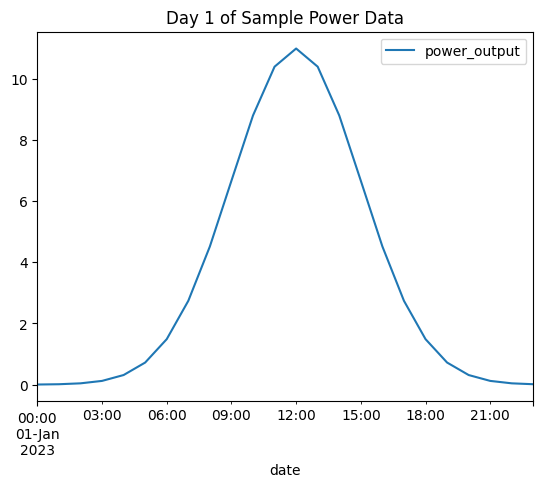

In [5]:
sample_df[0:24].plot(title="Day 1 of Sample Power Data")

<Axes: xlabel='date'>

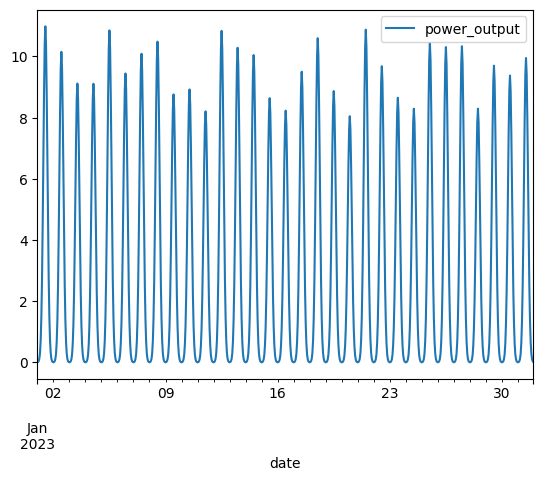

In [6]:
sample_df.plot()

## Identify the peak production hours and any anomalous dips in power generation

In [7]:
# Identify top 10 power output values
top_10_power = sample_df.sort_values(by="power_output", ascending=False)[0:10]
top_10_power

,power_output
date,
2023-01-01 12:00:00,10.980062
2023-01-21 12:00:00,10.869979
2023-01-05 12:00:00,10.845875
2023-01-12 12:00:00,10.831861
2023-01-18 12:00:00,10.592271
2023-01-08 12:00:00,10.479373
2023-01-25 12:00:00,10.436074
2023-01-01 13:00:00,10.386693
2023-01-01 11:00:00,10.386693


In [8]:
print(f"Top 10 power outputs, or 'peak production hours', are from hour {top_10_power.index.hour.min()} to {top_10_power.index.hour.max()}. ")

Top 10 power outputs, or 'peak production hours', are from hour 11 to 13. 


In [9]:
# Identify any anomalous dips in power generation
# First, to find anomalous dips, lets focus on peak hours -- hours 11 to 13 -- and find the 95th percentile
sample_df_peak_hours = sample_df[(sample_df.index.hour>=11)&(sample_df.index.hour<=13)]
min_threshold = sample_df_peak_hours["power_output"].quantile(0.05)

for hour, value in sample_df_peak_hours.iterrows():
    if value["power_output"] < min_threshold:
        print(f"Anomalous dip occurs at {hour} with value {round(value['power_output'],3)}")

Anomalous dip occurs at 2023-01-11 11:00:00 with value 7.757
Anomalous dip occurs at 2023-01-11 13:00:00 with value 7.757
Anomalous dip occurs at 2023-01-20 11:00:00 with value 7.608
Anomalous dip occurs at 2023-01-20 13:00:00 with value 7.608


## Include a brief explanation of how weather or other external factors might affect these readings

Cloudiness, seasonality, and other weather factors can impact the solar power output from the panels. Additionally, there could be either physical or software issues that impact the reading. For example, any shade imposed on the solar panels or any grime/dirt could significantly reduce the power output. There could also be inverter failures. Or simply, the software could be incorrectly reporting the pv power output. 

# Query Simulation for Energy Analytics

Prompt: "Assume you have a database (simulated as a Python dictionary provided below) containing information about various clean energy projects (solar, wind, hydroelectric) across different states. Write a Python script to query this database and find the top 5 states with the highest installed capacity for renewable energy."

Skills Tested: Database querying (simulated through Python), data analysis, knowledge of renewable energy trends.

In [10]:
energy_projects_data = {
    'California': [
        {'project_name': 'Solar Farm A', 'capacity_mw': 120, 'year_started': 2015},
        {'project_name': 'Wind Farm B', 'capacity_mw': 300, 'year_started': 2012},
        {'project_name': 'Hydroelectric C', 'capacity_mw': 50, 'year_started': 2010},
    ],
    'Texas': [
        {'project_name': 'Solar Farm D', 'capacity_mw': 180, 'year_started': 2018},
        {'project_name': 'Wind Farm E', 'capacity_mw': 500, 'year_started': 2011},
        {'project_name': 'Biomass F', 'capacity_mw': 75, 'year_started': 2014},
    ],
    'New York': [
        {'project_name': 'Solar Farm G', 'capacity_mw': 90, 'year_started': 2014},
        {'project_name': 'Wind Farm H', 'capacity_mw': 150, 'year_started': 2019},
        {'project_name': 'Geothermal I', 'capacity_mw': 25, 'year_started': 2016},
    ],
    'Massachusetts': [
        {'project_name': 'Solar Farm J', 'capacity_mw': 30, 'year_started': 2020},
        {'project_name': 'Hydroelectric K', 'capacity_mw': 20, 'year_started': 2009},
    ],
    'Illinois': [
        {'project_name': 'Wind Farm L', 'capacity_mw': 200, 'year_started': 2013},
        {'project_name': 'Solar Farm M', 'capacity_mw': 100, 'year_started': 2016},
    ],
    'Arizona': [
        {'project_name': 'Solar Farm N', 'capacity_mw': 150, 'year_started': 2017},
    ],
    'Florida': [
        {'project_name': 'Solar Farm O', 'capacity_mw': 110, 'year_started': 2015},
        {'project_name': 'Hydroelectric P', 'capacity_mw': 60, 'year_started': 2014},
    ],
    'Oregon': [
        {'project_name': 'Wind Farm Q', 'capacity_mw': 220, 'year_started': 2017},
        {'project_name': 'Hydroelectric R', 'capacity_mw': 180, 'year_started': 2013},
        {'project_name': 'Solar Farm S', 'capacity_mw': 55, 'year_started': 2018},
    ],
    'Washington': [
        {'project_name': 'Hydroelectric T', 'capacity_mw': 300, 'year_started': 2010},
        {'project_name': 'Wind Farm U', 'capacity_mw': 160, 'year_started': 2011},
    ],
    'Colorado': [
        {'project_name': 'Solar Farm V', 'capacity_mw': 130, 'year_started': 2019},
        {'project_name': 'Wind Farm W', 'capacity_mw': 155, 'year_started': 2020},
        {'project_name': 'Biomass X', 'capacity_mw': 45, 'year_started': 2013},
    ]
}

In [11]:
def top_5_states(capacity_dict):
    """ Query the sample dictionary and find the top 5 states with the highest installed capacity for renewable energy
    capacity_dict: a dictionary containing the state name in the first level, and the project name, capacity_mw, and year_started
                    in the second level
    return: dataframe with the top 5 states with highest installed capacity
    """
    top_5_states = pd.DataFrame(data=[
        {'state': state, 'capacity': sum(project['capacity_mw'] for project in projects)} for state, projects in capacity_dict.items()])
    
    
    return top_5_states.sort_values(by='capacity', ascending=False)[0:5]
    

In [12]:
top_5_states(capacity_dict=energy_projects_data)

,state,capacity
1,Texas,755
0,California,470
8,Washington,460
7,Oregon,455
9,Colorado,330


# Simulation of Energy Storage Systems

Prompt: "Create a Python simulation for a battery energy storage system. The simulation should take as input the storage capacity (in MWh), charge/discharge rates (in MW), energy costs, and simulate how the storage system responds to a given load profile over 24 hours. Your script should also calculate the efficiency losses due to charging and discharging and demonstrate how energy storage can aid in load balancing."

Skills Tested: Understanding of energy storage systems, simulation skills, basic physics and engineering principles related to energy efficiency.

<Axes: title={'center': 'Sample Load Data for One Day'}>

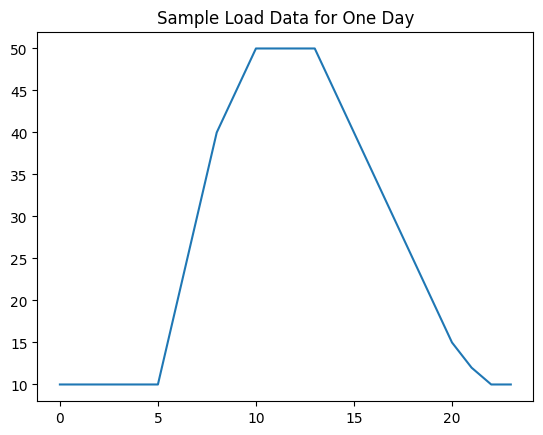

In [13]:
# Sample hourly load profile data in MW
load_data = {
    'hour': range(24),
    'demand_mw': [
        10, 10, 10, 10, 10, 10,  # 00:00 - 05:00 Low demand
        20, 30, 40, 45, 50, 50,  # 06:00 - 11:00 Increasing demand
        50, 50, 45, 40, 35, 30,  # 12:00 - 17:00 High demand
        25, 20, 15, 12, 10, 10   # 18:00 - 23:00 Decreasing demand
    ]
}

# Create a DataFrame
load_profile_df = pd.DataFrame(load_data)

# Display the DataFrame
load_profile_df['demand_mw'].plot(title="Sample Load Data for One Day")

<Axes: title={'center': 'Costs for One Day'}>

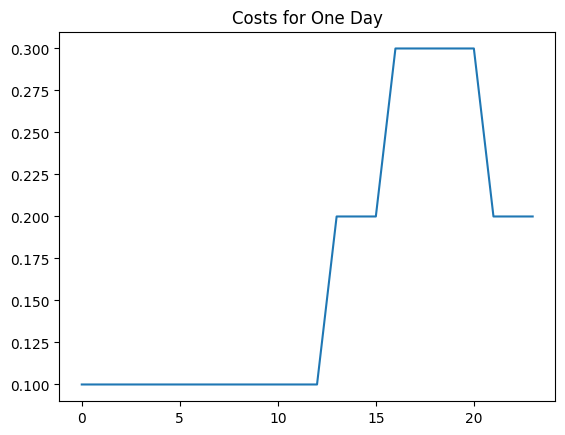

In [14]:
# Sample hourly energy cost data in $/MW
# Highest costs, the "peak period", is from 16:00-21:00 
# The partial peak period is 3 hours before and 3 hours after the peak period
cost_data = {
    'hour': range(24),
    'cost_mw': [
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 00:00 - 05:00 Low cost
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 06:00 - 11:00 Low cost
        0.1, 0.2, 0.2, 0.2, 0.3, 0.3,  # 12:00 - 17:00 Low-Med-High cost
        0.3, 0.3, 0.3, 0.2, 0.2, 0.2   # 18:00 - 23:00 High-Med-Low cost
    ]
}

# Create a DataFrame
cost_profile_df = pd.DataFrame(cost_data)

# Display the DataFrame
cost_profile_df['cost_mw'].plot(title="Costs for One Day")

In [15]:
# Combine load and cost dataframes
load_cost = load_profile_df.copy()
load_cost["cost_mw"] = cost_profile_df['cost_mw']
load_cost.set_index("hour", inplace=True)

load_cost

,demand_mw,cost_mw
hour,,
0,10,0.1
1,10,0.1
2,10,0.1
3,10,0.1
4,10,0.1
5,10,0.1
6,20,0.1
7,30,0.1
8,40,0.1


Decision Variables
- C_t is the amount of energy (MWh) charged in hour t
- D_t is the amount of energy (MWh) discharged in hour t
- SOC_t is the amount of energy (MWh) available in the battery in hour t
- Grid_t is the amount of energy (MWh) drawn from the grid in hour t

Parameters
- ESS_CAPACITY: the maximum battery capacity in MWh
- ESS_CHARGE_RATE: the maximum battery charge rate in MW
- ESS_DISCHARGE_RATE: the maximum battery discharge rate in MW
- RTE: the the round trip efficiency of the battery in percent (%)
- demand_t or demand_mw: the demand of the load at hour t (MWh)
- price_t or cost_mw: the cost of the energy at hour t ($/MWh)

Constraints
- 0 <= SOC_t <= ESS_CAPACITY for t from 0-24
- 0 <= C_t <= ESS_CHARGE_RATE
- 0 <= D_t <= ESS_DISCHARGE_RATE
- D_t <= SOC_t
- SOC_t = SOC_t-1 + C_t - D_t/RTE  (accounting for RTE losses) for t from 0-24
- D_t + grid_t >= demand_t
- SOC_0 = 0 initial boundary condition
- grid_t = max(demand_t - D_t, 0)
- D_t * C_t = 0 (note that i model this differently using binary decision variables, see below)

Objective
- Minimize the cost of energy for the building load across one day using a battery
min(sum((grid_t)*price_t) for t from 0-24)

In [16]:
# Initialize parameters
ESS_CAPACITY = 30 # MWH
ESS_CHARGE_RATE = 15 # MW
ESS_DISCHARGE_RATE = 15 # MW
RTE = 0.88

# demand_t is the column demand_mw from the load_cost dataframe
# price_t is the column cost_mw from the load_cost dataframe

In [17]:
# Create a PuLP model
model = pulp.LpProblem("Battery Optimization", pulp.LpMinimize)

# Decision Variables
charge = pulp.LpVariable.dicts("Charge", load_cost.index, lowBound=0, cat='Continuous')
discharge = pulp.LpVariable.dicts("Discharge", load_cost.index, lowBound=0, cat='Continuous')
soc = pulp.LpVariable.dicts("SOC", load_cost.index, lowBound=0, cat='Continuous')
grid = pulp.LpVariable.dicts("Grid", load_cost.index, lowBound=0, cat='Continuous')

# Since charge[t] * discharge[t] == 0 is a non-linear problem we re-establish using binary variables
is_charging = pulp.LpVariable.dicts("IsCharging", load_cost.index, cat='Binary')
is_discharging = pulp.LpVariable.dicts("IsDischarging", load_cost.index, cat='Binary')

# Establish RTE inverse since PuLP does not allow division by float
RTE_inverse = 1/RTE

# Objective Function
model += pulp.lpSum([grid[t] * load_cost.cost_mw[t] for t in load_cost.index])

# Constraints
for t in load_cost.index:
    if t == 0:
        # Initial boundary condition
        model += soc[t] == 0
    else:
        # SOC constraint
        model += 0 <= soc[t] <= ESS_CAPACITY
        # Maximum charge/discharge rate constraints
        model += charge[t] <= ESS_CHARGE_RATE * is_charging[t]
        model += discharge[t] <= ESS_DISCHARGE_RATE * is_discharging[t]
        # Discharge cannot be greater than SOC available
        model += discharge[t] <= soc[t]
        # Account for RTE when calculating SOC
        model += soc[t] == soc[t-1] + charge[t] - discharge[t] * RTE_inverse
        # Ensure building demand is met
        model += discharge[t] + grid[t] >= load_cost.demand_mw[t]
        # Define grid, ensure it cannot go negative 
        model += grid[t] == load_cost.demand_mw[t] - discharge[t] + charge[t]
        model += grid[t] >= 0
        # Ensure battery can't charge and discharge simultaneously
        model += is_charging[t] + is_discharging[t] <= 1

# Solve the model
model.solve()

# Print the results
for t in load_cost.index:
    print(f"Hour {load_cost.index}: Charge = {charge[t].varValue} MWh, Discharge = {discharge[t].varValue} MWh")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/5e4febd9dae042ad8a141a4153010f3a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/5e4febd9dae042ad8a141a4153010f3a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 213 COLUMNS
At line 768 RHS
At line 977 BOUNDS
At line 1024 ENDATA
Problem MODEL has 208 rows, 140 columns and 438 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 99.5515 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 127 rows, 118 columns (44 integer (44 of which binary)) and 306 elements
Cbc0038I Initial state - 8 integers unsatisfied sum - 

/Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [18]:

# Extracting results from the PuLP model
results = {
    'Hour': load_cost.index,
    'Charge': [charge[t].varValue for t in load_cost.index],
    'Discharge': [discharge[t].varValue for t in load_cost.index],
    'SOC': [soc[t].varValue for t in load_cost.index],
    'Grid': [grid[t].varValue for t in load_cost.index],
    'Demand': load_cost['demand_mw'],
    'Cost': load_cost['cost_mw']
}

results_df = pd.DataFrame(results).set_index('Hour')


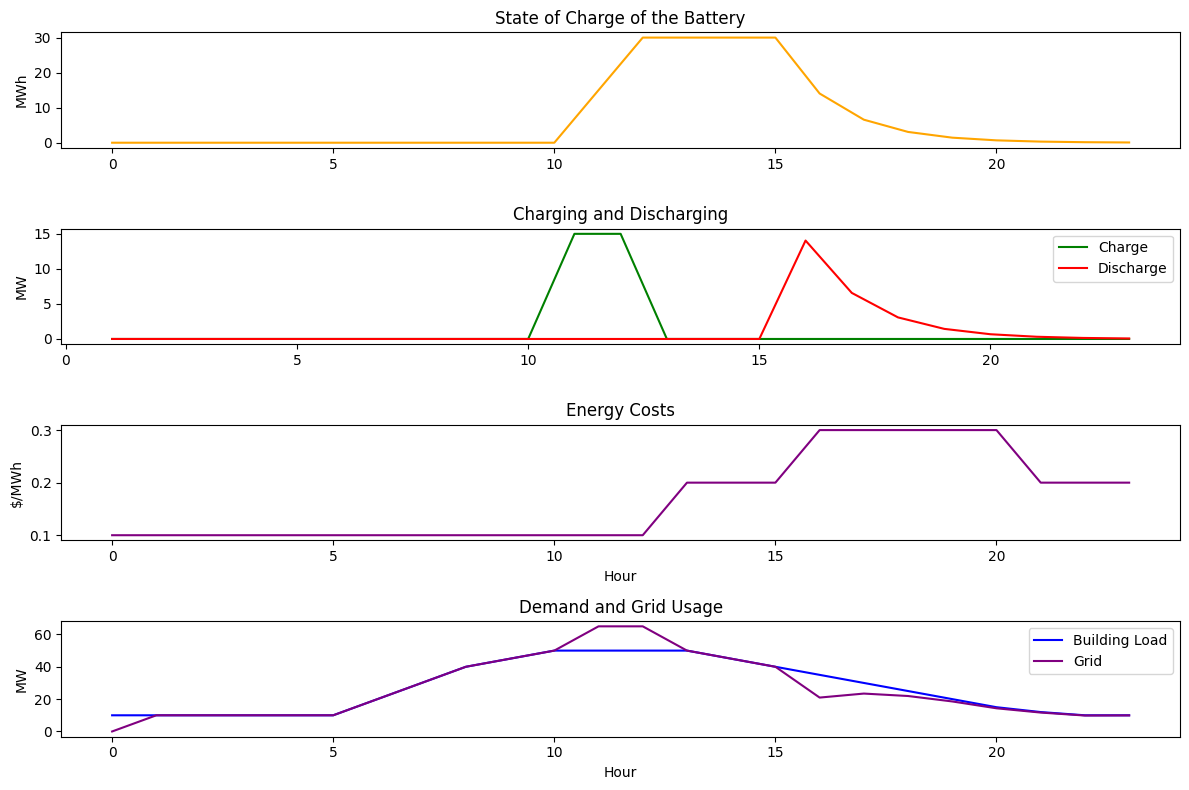

In [19]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(results_df.index, results_df['SOC'], label='State of Charge', color='orange')
plt.ylabel('MWh')
plt.title('State of Charge of the Battery')

plt.subplot(4, 1, 2)
plt.plot(results_df.index, results_df['Charge'], label='Charge', color='green')
plt.plot(results_df.index, results_df['Discharge'], label='Discharge', color='red')
plt.ylabel('MW')
plt.legend()
plt.title('Charging and Discharging')

plt.subplot(4, 1, 3)
plt.plot(results_df.index, results_df['Cost'], label='Energy Costs', color='purple')
plt.xlabel('Hour')
plt.ylabel('$/MWh')
plt.title('Energy Costs')

plt.subplot(4, 1, 4)
plt.plot(results_df.index, results_df['Demand'], label='Building Load', color='blue')
plt.plot(results_df.index, results_df['Grid'], label='Grid', color='purple')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.title('Demand and Grid Usage')

plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Given that in the real world, a battery needs to have smooth charging and discharging, I want to impose 
# a smoothing function. This is tricky given that we are operating with a linear program, but I can place a small penalty on the battery for 
# switching state, which may achieve this result

In [21]:
# Create a PuLP model
model = pulp.LpProblem("Battery Optimization", pulp.LpMinimize)

# Decision Variables
charge = pulp.LpVariable.dicts("Charge", load_cost.index, lowBound=0, cat='Continuous')
discharge = pulp.LpVariable.dicts("Discharge", load_cost.index, lowBound=0, cat='Continuous')
soc = pulp.LpVariable.dicts("SOC", load_cost.index, lowBound=0, cat='Continuous')
grid = pulp.LpVariable.dicts("Grid", load_cost.index, lowBound=0, cat='Continuous')

# Since charge[t] * discharge[t] == 0 is a non-linear problem we re-establish using binary variables
is_charging = pulp.LpVariable.dicts("IsCharging", load_cost.index, cat='Binary')
is_discharging = pulp.LpVariable.dicts("IsDischarging", load_cost.index, cat='Binary')

# Create a persistent state decision variable for charging and discharging
persistent_charge = pulp.LpVariable.dicts("PersistentCharge", load_cost.index, lowBound=0, cat='Continuous')
persistent_discharge = pulp.LpVariable.dicts("PersistentDischarge", load_cost.index, lowBound=0, cat='Continuous')

# Establish RTE inverse since PuLP does not allow division by float
RTE_inverse = 1/RTE

# Add a small cost to the objective function for each change in persistence
SWITCH_COST = 0.05  # A small cost to disincentivize switching (equivalent to half the off peak price)

# Objective Function
model += pulp.lpSum([grid[t] * load_cost.cost_mw[t] for t in load_cost.index]) + SWITCH_COST * (pulp.lpSum([persistent_charge[t] for t in load_cost.index[1:]]) + pulp.lpSum([persistent_discharge[t] for t in load_cost.index[1:]]))

# Constraints
for t in load_cost.index:
    if t == 0:
        # Initial boundary condition
        model += soc[t] == 0
        model += persistent_charge[t] == 0
        model += persistent_discharge[t] == 0
    else:
        # SOC constraint
        model += 0 <= soc[t] <= ESS_CAPACITY
        # Maximum charge/discharge rate constraints
        model += charge[t] <= ESS_CHARGE_RATE * is_charging[t]
        model += discharge[t] <= ESS_DISCHARGE_RATE * is_discharging[t]
        # Discharge cannot be greater than SOC available
        model += discharge[t] <= soc[t]
        # Account for RTE when calculating SOC
        model += soc[t] == soc[t-1] + charge[t] - discharge[t] * RTE_inverse
        # Ensure building demand is met
        model += discharge[t] + grid[t] >= load_cost.demand_mw[t]
        # Define grid, ensure it cannot go negative 
        model += grid[t] == load_cost.demand_mw[t] - discharge[t] + charge[t]
        model += grid[t] >= 0
        # Ensure battery can't charge and discharge simultaneously
        model += is_charging[t] + is_discharging[t] <= 1
        # Charging persistence constraints
        model += persistent_charge[t] >= charge[t] - charge[t-1]
        model += persistent_charge[t] >= charge[t-1] - charge[t]
        # Discharging persistence constraints
        model += persistent_discharge[t] >= discharge[t] - discharge[t-1]
        model += persistent_discharge[t] >= discharge[t-1] - discharge[t]

# Solve the model
model.solve()

# Print the results
for t in load_cost.index:
    print(f"Hour {load_cost.index}: Charge = {charge[t].varValue} MWh, Discharge = {discharge[t].varValue} MWh")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c7a43dabada94ad2b7831ce048bc3985-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c7a43dabada94ad2b7831ce048bc3985-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 307 COLUMNS
At line 1186 RHS
At line 1489 BOUNDS
At line 1536 ENDATA
Problem MODEL has 302 rows, 190 columns and 716 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 100.402 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 218 rows, 166 columns (46 integer (46 of which binary)) and 579 elements
Cbc0038I Initial state - 20 integers unsatisfied sum

In [22]:

# Extracting results from the PuLP model
results = {
    'Hour': load_cost.index,
    'Charge': [charge[t].varValue for t in load_cost.index],
    'Discharge': [discharge[t].varValue for t in load_cost.index],
    'SOC': [soc[t].varValue for t in load_cost.index],
    'Grid': [grid[t].varValue for t in load_cost.index],
    'Demand': load_cost['demand_mw'],
    'Cost': load_cost['cost_mw']
}

results_df = pd.DataFrame(results).set_index('Hour')


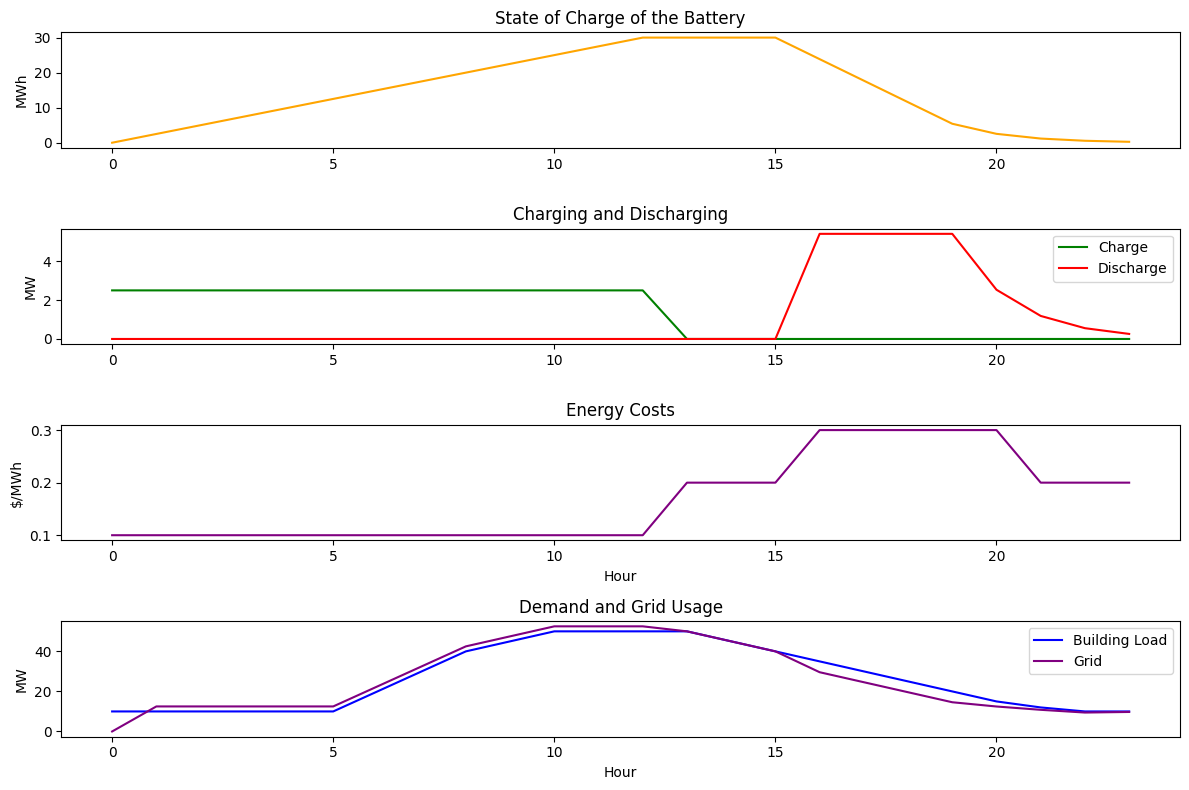

In [23]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(results_df.index, results_df['SOC'], label='State of Charge', color='orange')
plt.ylabel('MWh')
plt.title('State of Charge of the Battery')

plt.subplot(4, 1, 2)
plt.plot(results_df.index, results_df['Charge'], label='Charge', color='green')
plt.plot(results_df.index, results_df['Discharge'], label='Discharge', color='red')
plt.ylabel('MW')
plt.legend()
plt.title('Charging and Discharging')

plt.subplot(4, 1, 3)
plt.plot(results_df.index, results_df['Cost'], label='Energy Costs', color='purple')
plt.xlabel('Hour')
plt.ylabel('$/MWh')
plt.title('Energy Costs')

plt.subplot(4, 1, 4)
plt.plot(results_df.index, results_df['Demand'], label='Building Load', color='blue')
plt.plot(results_df.index, results_df['Grid'], label='Grid', color='purple')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.title('Demand and Grid Usage')

plt.legend()
plt.tight_layout()
plt.show()


In [38]:
#grid #[2].varValue

To be continued on optimization_problems_ess_simulation.ipynb!